# 0 - References

- https://www.kaggle.com/code/sulianova/eda-cardiovascular-data/notebook

# 1 - Import Libraries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

# 2 - Import Data

In [2]:
df = pd.read_csv('ML_cardio_dataSet_final.csv')

# 3 - Inspect Data

In [3]:
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,4,17474,f,156,56.0,100,60,1,1,0,0,0,0
2,8,21914,1,151,67.0,120,80,2,2,0,0,0,0
3,9,22113,1,157,93.0,130,80,3,1,0,0,1,0
4,13,17668,1,158,71.0,110,70,1,1,0,0,1,0


## 3.1 - Data

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64511 entries, 0 to 64510
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           64511 non-null  int64  
 1   age          64511 non-null  int64  
 2   gender       64511 non-null  object 
 3   height       64511 non-null  int64  
 4   weight       64511 non-null  float64
 5   ap_hi        64511 non-null  int64  
 6   ap_lo        64511 non-null  int64  
 7   cholesterol  64511 non-null  int64  
 8   gluc         64511 non-null  int64  
 9   smoke        64511 non-null  int64  
 10  alco         64511 non-null  int64  
 11  active       64511 non-null  int64  
 12  cardio       64511 non-null  int64  
dtypes: float64(1), int64(11), object(1)
memory usage: 6.4+ MB


In [5]:
df.memory_usage(index=True).sum() / 1000000

6.709276

## 3.2 - Columns

In [6]:
df.columns

Index(['id', 'age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo',
       'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio'],
      dtype='object')

## 3.3 - Statistics

In [7]:
df.describe()

,id,age,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,64511.000000,64511.000000,64511.000000,64511.000000,64511.000000,64511.000000,64511.000000,64511.000000,64511.000000,64511.000000,64511.000000,64511.000000
mean,53562.084482,19420.396847,164.364651,73.977297,128.201144,95.240796,1.353955,1.222768,0.088419,0.053898,0.805258,0.457116
std,27150.759446,2473.001103,8.215813,14.303907,153.850257,179.103902,0.669552,0.568043,0.283906,0.225818,0.396005,0.498161
min,0.000000,10798.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,30880.500000,17605.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,53891.000000,19673.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,76850.500000,21290.000000,170.000000,82.000000,140.000000,90.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,99999.000000,23713.000000,207.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


<Axes: >

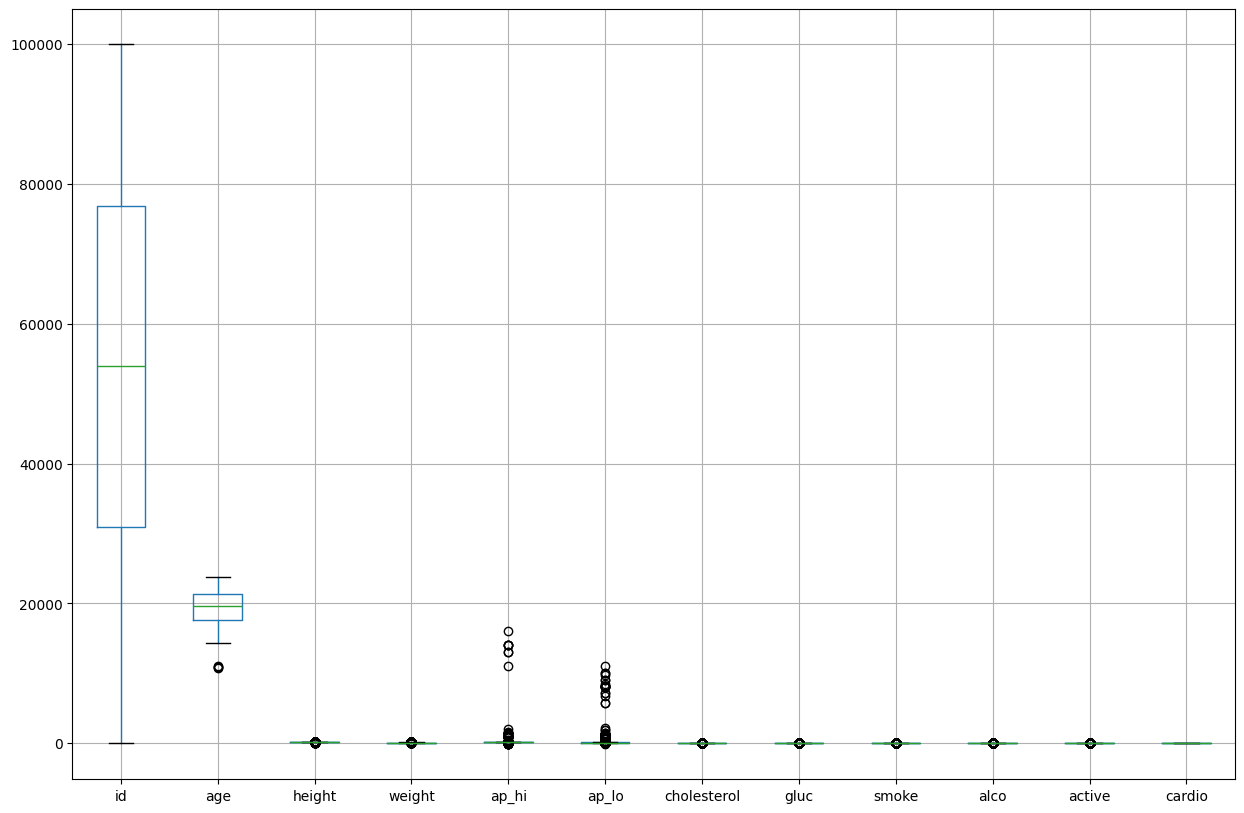

In [8]:
df.boxplot(figsize=(15, 10))

# 4 - Clean Data

In [9]:
df.isnull().sum()

id             0
age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64

## 4.1 - Gender column

This column needs to contain '1' for female, '2' for male. At the moment, there are a few non-standardised values such as 'm', 'f', 'MALE', and 'FEMALE'.

In [10]:
df['gender'].unique()

array(['2', 'f', '1', 'F', 'm', 'MALE', 'FEMALE'], dtype=object)

In [11]:
df['gender'].replace('f', '1', inplace=True)
df['gender'].replace('F', '1', inplace=True)
df['gender'].replace('FEMALE', '1', inplace=True)
df['gender'].replace('m', '2', inplace=True)
df['gender'].replace('MALE', '2', inplace=True)

df["gender"] = pd.to_numeric(df["gender"])

In [12]:
df['gender'].unique()

array([2, 1])

## 4.2 - Height column

The minimum recorded height in the original data was 55cm, a guaranteed erroneous input since the age ranges from 29 to 65 years old. Likewise, the maximum height is 207cm, which though hard to tell if it's erroneous, it can be safely treated as an outlier.

Remove the heights that fall below 2.5% or above the 97.5% percentiles.

In [13]:
df.drop(df[(df['height'] > df['height'].quantile(0.975)) | (df['height'] < df['height'].quantile(0.025))].index,inplace=True)

## 4.3 - Weight column

The minimum recorded weight in the original data set was 10kg, similar the the smallest height this is an erroneous input.

Remove the weights that fall below 2.5% or above the 97.5% percentiles.

In [14]:
df.drop(df[(df['weight'] > df['weight'].quantile(0.975)) | (df['weight'] < df['weight'].quantile(0.025))].index,inplace=True)

## 4.4 - Systolic and diastolic blood pressure columns

Systolic is the higher blood pressure recording compared to diastolic, it shouldn't be possible to have instances the other way around. Furthermore, it is not possible to have negative blood pressure readings.

Remove the readings that fall below 2.5% or above the 97.5% percentiles.

In [15]:
print("Diastilic pressure is higher than systolic one in {0} cases".format(df[df['ap_lo']> df['ap_hi']].shape[0]))

Diastilic pressure is higher than systolic one in 945 cases


In [16]:
df.drop(df[(df['ap_hi'] > df['ap_hi'].quantile(0.975)) | (df['ap_hi'] < df['ap_hi'].quantile(0.025))].index,inplace=True)
df.drop(df[(df['ap_lo'] > df['ap_lo'].quantile(0.975)) | (df['ap_lo'] < df['ap_lo'].quantile(0.025))].index,inplace=True)

In [17]:
print("Diastilic pressure is higher than systolic one in {0} cases".format(df[df['ap_lo']> df['ap_hi']].shape[0]))

Diastilic pressure is higher than systolic one in 0 cases


Diastilic pressure is higher than systolic one in 0 cases


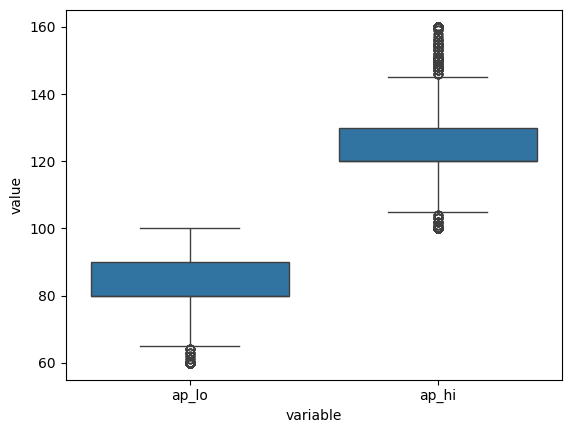

In [18]:
blood_pressure = df.loc[:,['ap_lo','ap_hi']]
sns.boxplot(x = 'variable',y = 'value',data = blood_pressure.melt())
print("Diastilic pressure is higher than systolic one in {0} cases".format(df[df['ap_lo']> df['ap_hi']].shape[0]))

## 4.5 ID column

In [19]:
df = df.drop('id', axis=1)

## 4.6 Age column

In [20]:
df['age'] = (df['age'] / 365).round().astype('int')

## 4.7 - Height & weight columns

BMI = weight (kg) / (height (m))^2

In [21]:
df["bmi"] = df["weight"]/((df["height"]/100)**2)
df["bmi"] = df["bmi"].round(2)

In [22]:
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi
0,50,2,168,62.0,110,80,1,1,0,0,1,0,21.97
1,48,1,156,56.0,100,60,1,1,0,0,0,0,23.01
2,60,1,151,67.0,120,80,2,2,0,0,0,0,29.38
3,61,1,157,93.0,130,80,3,1,0,0,1,0,37.73
4,48,1,158,71.0,110,70,1,1,0,0,1,0,28.44


Once the BMI column has been computed and added, we can drop the height and weight columns

In [23]:
df.drop(["height","weight"],axis=1,inplace=True)

Remove the readings that fall below 2.5% or above the 97.5% percentiles.

In [24]:
df.drop(df[(df['bmi'] > df['bmi'].quantile(0.975)) | (df['bmi'] < df['bmi'].quantile(0.025))].index,inplace=True)

## 4.8 Duplicate rows

In [25]:
df.duplicated().sum()

4240

In [26]:
df[df.duplicated()]

,age,gender,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi
211,55,1,140,90,2,1,0,0,1,0,28.72
223,50,1,130,80,1,2,0,0,1,0,25.31
253,58,2,120,80,1,1,0,0,1,0,23.05
339,56,1,120,80,1,1,0,0,1,0,23.44
409,41,2,120,80,1,1,0,0,0,0,22.04
...,...,...,...,...,...,...,...,...,...,...,...
64452,46,1,120,80,1,1,0,0,1,0,30.12
64462,42,1,110,70,1,1,0,0,1,0,22.03
64494,54,1,120,80,1,1,0,0,1,0,26.45
64497,50,2,120,80,1,1,0,0,1,0,24.07


In [27]:
df.drop_duplicates(inplace=True)

## 4.9 - Post-clean review

In [28]:
df.duplicated().sum()

0

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48579 entries, 0 to 64510
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          48579 non-null  int64  
 1   gender       48579 non-null  int64  
 2   ap_hi        48579 non-null  int64  
 3   ap_lo        48579 non-null  int64  
 4   cholesterol  48579 non-null  int64  
 5   gluc         48579 non-null  int64  
 6   smoke        48579 non-null  int64  
 7   alco         48579 non-null  int64  
 8   active       48579 non-null  int64  
 9   cardio       48579 non-null  int64  
 10  bmi          48579 non-null  float64
dtypes: float64(1), int64(10)
memory usage: 4.4 MB


In [30]:
df.memory_usage(index=True).sum() / 1000000

4.663584

In [31]:
df.describe()

,age,gender,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi
count,48579.000000,48579.000000,48579.000000,48579.000000,48579.000000,48579.000000,48579.000000,48579.000000,48579.000000,48579.000000,48579.000000
mean,53.264538,1.363532,125.664526,80.911587,1.360485,1.230861,0.092550,0.055868,0.796332,0.464748,27.120757
std,6.808835,0.481021,13.909116,8.401144,0.673746,0.579223,0.289804,0.229669,0.402729,0.498761,3.867657
min,30.000000,1.000000,100.000000,60.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,20.570000
25%,48.000000,1.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,24.070000
50%,54.000000,1.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,26.440000
75%,58.000000,2.000000,135.000000,90.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,29.720000
max,65.000000,2.000000,160.000000,100.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000,37.460000


# 5 - Data Visualisation

## 5.1 - BP w.r.t. CVD

/var/folders/gh/fp8cyv3j0xv6hnfcq67g5b4w0000gn/T/ipykernel_42336/2902736296.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  hibp_cvd_bar.set_xticklabels(hibp_cvd_bar.get_xticklabels(), rotation=-90)
/var/folders/gh/fp8cyv3j0xv6hnfcq67g5b4w0000gn/T/ipykernel_42336/2902736296.py:54: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  lobp_cvd_bar.set_xticklabels(lobp_cvd_bar.get_xticklabels(), rotation=-90)


Text(0, 0.5, 'Normalised CVD Presence')

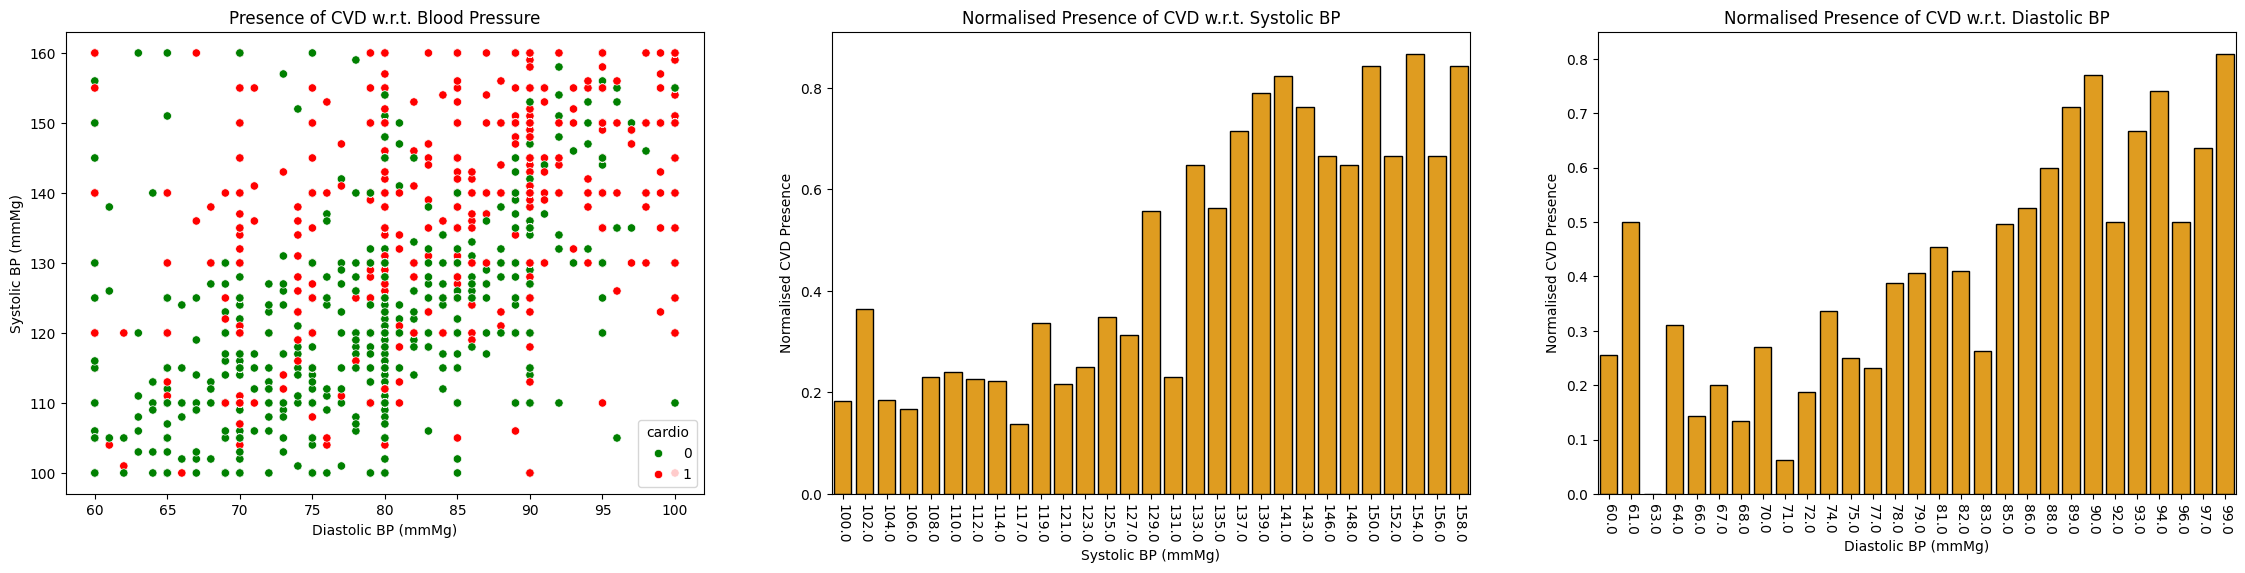

In [32]:
fig, axes = plt.subplots(1, 3, figsize=(28, 6))

bp_cvd_scatter = sns.scatterplot(
    data=df,
    x='ap_lo',
    y='ap_hi',
    hue='cardio',
    palette={
        1: 'red',
        0: 'green'
    },
    ax=axes[0]
)
bp_cvd_scatter.set_title("Presence of CVD w.r.t. Blood Pressure")
bp_cvd_scatter.set_xlabel("Diastolic BP (mmMg)")
bp_cvd_scatter.set_ylabel("Systolic BP (mmMg)")

cvd_present = df[df['cardio'] == 1]
cvd_absent = df[df['cardio'] == 0]

num_bins = 30
hi_bins=np.linspace(df['ap_hi'].min(),df['ap_hi'].max(),num_bins)
lo_bins=np.linspace(df['ap_lo'].min(),df['ap_lo'].max(),num_bins)

hi_cvd_present_hist = np.histogram(cvd_present['ap_hi'],bins=hi_bins)
hi_cvd_absent_hist = np.histogram(cvd_absent['ap_hi'],bins=hi_bins)

lo_cvd_present_hist = np.histogram(cvd_present['ap_lo'],bins=lo_bins)
lo_cvd_absent_hist = np.histogram(cvd_absent['ap_lo'],bins=lo_bins)

hi_cvd_rates = hi_cvd_present_hist[0]/(hi_cvd_present_hist[0]+hi_cvd_absent_hist[0])
lo_cvd_rates = lo_cvd_present_hist[0]/(lo_cvd_present_hist[0]+lo_cvd_absent_hist[0])

hibp_cvd_bar = sns.barplot(
    x=hi_bins[:-1].round(),
    y=hi_cvd_rates,
    ax=axes[1],
    color='orange',
    edgecolor="0",
)
hibp_cvd_bar.set_title("Normalised Presence of CVD w.r.t. Systolic BP")
hibp_cvd_bar.set_xticklabels(hibp_cvd_bar.get_xticklabels(), rotation=-90)
hibp_cvd_bar.set_xlabel("Systolic BP (mmMg)")
hibp_cvd_bar.set_ylabel("Normalised CVD Presence")

lobp_cvd_bar = sns.barplot(
    x=lo_bins[:-1].round(),
    y=lo_cvd_rates,
    ax=axes[2],
    color='orange',
    edgecolor="0",
)
lobp_cvd_bar.set_title("Normalised Presence of CVD w.r.t. Diastolic BP")
lobp_cvd_bar.set_xticklabels(lobp_cvd_bar.get_xticklabels(), rotation=-90)
lobp_cvd_bar.set_xlabel("Diastolic BP (mmMg)")
lobp_cvd_bar.set_ylabel("Normalised CVD Presence")

## 5.2 - Smoking w.r.t. CVD

Text(0, 0.5, 'Normalised Magnitude of CVD Presence')

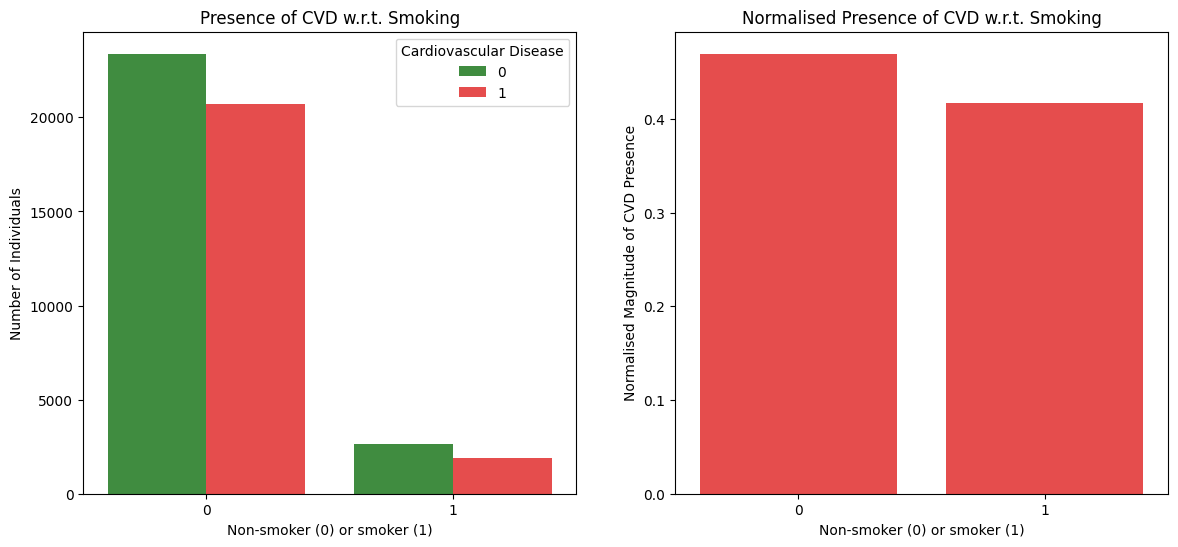

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Grouping by 'smoke' and 'cardio' columns and calculating counts
grouped = df.groupby(['smoke', 'cardio']).size().unstack().reset_index()

# Melt the DataFrame for Seaborn's barplot
melted = pd.melt(grouped, id_vars='smoke', var_name='Cardiovascular Disease', value_name='Count')

smoke_cvd_bar = sns.barplot(
    data=melted,
    x='smoke',
    y='Count',
    hue='Cardiovascular Disease',
    palette={0: 'green', 1: 'red'},
    alpha=0.8,
    ax=axes[0]
)
smoke_cvd_bar.set_title("Presence of CVD w.r.t. Smoking")
smoke_cvd_bar.set_xlabel("Non-smoker (0) or smoker (1)")
smoke_cvd_bar.set_ylabel("Number of Individuals")

# Calculate percentages
grouped_total = df.groupby('smoke').size().reset_index(name='Total')
grouped_cvd = df[df['cardio'] == 1].groupby('smoke').size().reset_index(name='CVD')

# Merge the total and CVD counts
merged = pd.merge(grouped_total, grouped_cvd, on='smoke')

# Calculate percentages
merged['Percentage_CVD'] = merged['CVD'] / merged['Total']

# Plotting the stacked bar plot
smoke_cvd_norm_bar = sns.barplot(
    data=merged,
    x='smoke',
    y='Percentage_CVD',
    color='red',
    alpha=0.8,
    ax=axes[1]
)
smoke_cvd_norm_bar.set_title("Normalised Presence of CVD w.r.t. Smoking")
smoke_cvd_norm_bar.set_xlabel("Non-smoker (0) or smoker (1)")
smoke_cvd_norm_bar.set_ylabel("Normalised Magnitude of CVD Presence")


## 5.3 - Cholesterol w.r.t. CVD

Text(0, 0.5, 'Normalised Magnitude of CVD Presence')

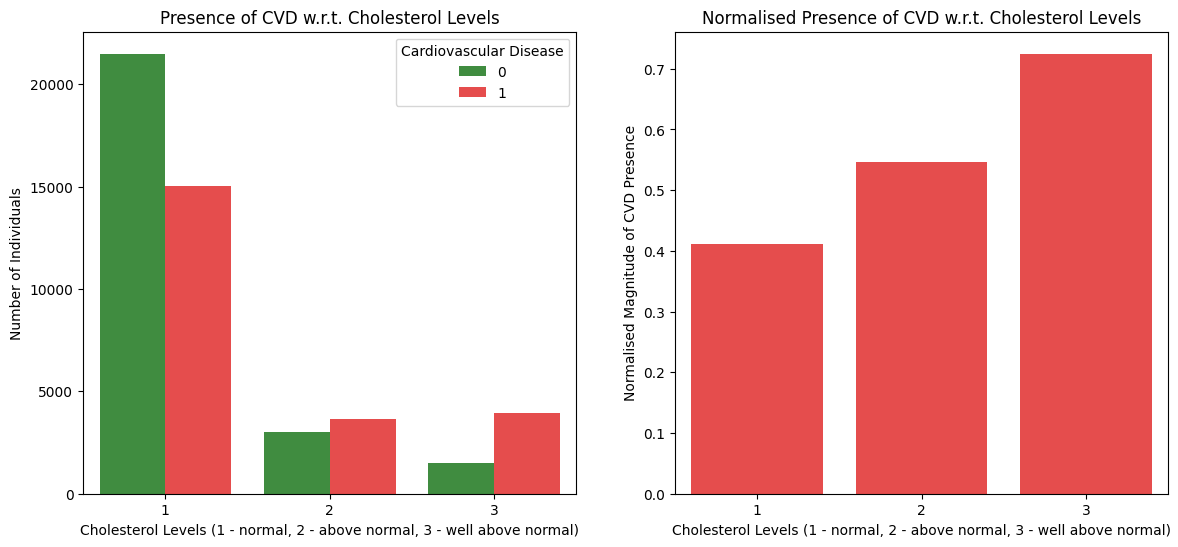

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Grouping by 'cholesterol' and 'cardio' columns and calculating counts
grouped = df.groupby(['cholesterol', 'cardio']).size().unstack().reset_index()

# Melt the DataFrame for Seaborn's barplot
melted = pd.melt(grouped, id_vars='cholesterol', var_name='Cardiovascular Disease', value_name='Count')

chol_cvd_bar = sns.barplot(data=melted, x='cholesterol', y='Count', hue='Cardiovascular Disease', palette={0: 'green', 1: 'red'}, alpha=0.8, ax=axes[0])
chol_cvd_bar.set_title("Presence of CVD w.r.t. Cholesterol Levels")
chol_cvd_bar.set_xlabel("Cholesterol Levels (1 - normal, 2 - above normal, 3 - well above normal)")
chol_cvd_bar.set_ylabel("Number of Individuals")



# Calculate percentages
grouped_total = df.groupby('cholesterol').size().reset_index(name='Total')
grouped_cvd = df[df['cardio'] == 1].groupby('cholesterol').size().reset_index(name='CVD')

# Merge the total and CVD counts
merged = pd.merge(grouped_total, grouped_cvd, on='cholesterol')

# Calculate percentages
merged['Percentage_CVD'] = (merged['CVD'] / merged['Total'])

# Plotting the stacked bar plot
chol_cvd_norm_bar = sns.barplot(data=merged, x='cholesterol', y='Percentage_CVD', color='red', alpha=0.8, ax=axes[1])
chol_cvd_norm_bar.set_title("Normalised Presence of CVD w.r.t. Cholesterol Levels")
chol_cvd_norm_bar.set_xlabel("Cholesterol Levels (1 - normal, 2 - above normal, 3 - well above normal)")
chol_cvd_norm_bar.set_ylabel("Normalised Magnitude of CVD Presence")

## 5.4 - Glucose w.r.t. CVD

Text(0, 0.5, 'Normalised Magnitude of CVD Presence')

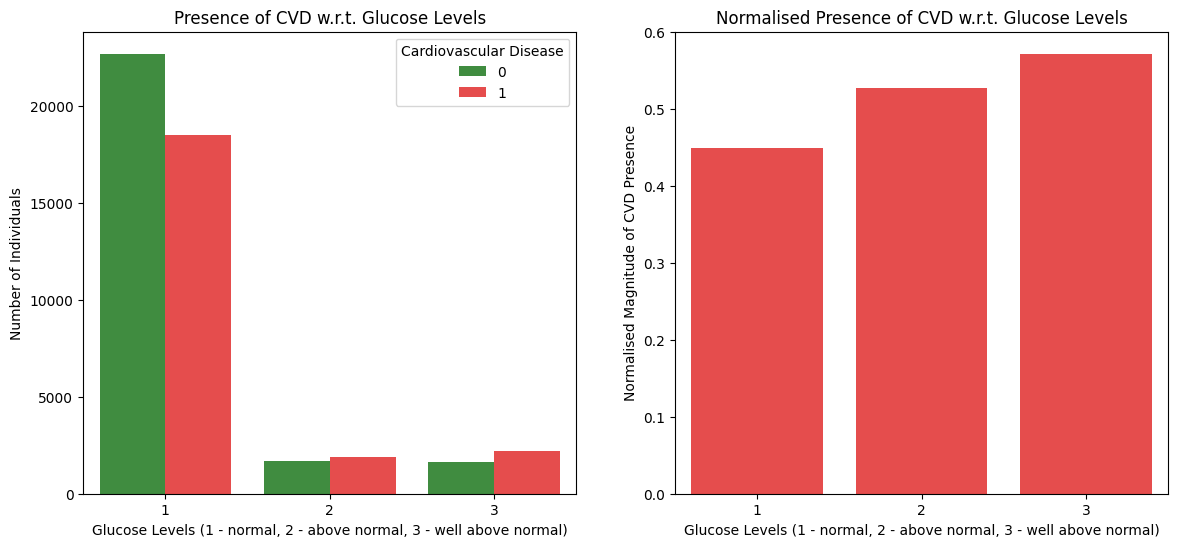

In [35]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Grouping by 'gluc' and 'cardio' columns and calculating counts
grouped = df.groupby(['gluc', 'cardio']).size().unstack().reset_index()

# Melt the DataFrame for Seaborn's barplot
melted = pd.melt(grouped, id_vars='gluc', var_name='Cardiovascular Disease', value_name='Count')

gluc_cvd_bar = sns.barplot(data=melted, x='gluc', y='Count', hue='Cardiovascular Disease', palette={0: 'green', 1: 'red'}, alpha=0.8, ax=axes[0])
gluc_cvd_bar.set_title("Presence of CVD w.r.t. Glucose Levels")
gluc_cvd_bar.set_xlabel("Glucose Levels (1 - normal, 2 - above normal, 3 - well above normal)")
gluc_cvd_bar.set_ylabel("Number of Individuals")


# Calculate percentages
grouped_total = df.groupby('gluc').size().reset_index(name='Total')
grouped_cvd = df[df['cardio'] == 1].groupby('gluc').size().reset_index(name='CVD')

# Merge the total and CVD counts
merged = pd.merge(grouped_total, grouped_cvd, on='gluc')

# Calculate percentages
merged['Percentage_gluc'] = (merged['CVD'] / merged['Total'])

# Plotting the stacked bar plot
gluc_cvd_norm_bar = sns.barplot(data=merged, x='gluc', y='Percentage_gluc', color='red',  alpha=0.8, ax=axes[1])
gluc_cvd_norm_bar.set_title("Normalised Presence of CVD w.r.t. Glucose Levels")
gluc_cvd_norm_bar.set_xlabel("Glucose Levels (1 - normal, 2 - above normal, 3 - well above normal)")
gluc_cvd_norm_bar.set_ylabel("Normalised Magnitude of CVD Presence")

## 5.5 - Inactivity w.r.t. CVD

Text(0, 0.5, 'Normalised Magnitude of CVD Presence')

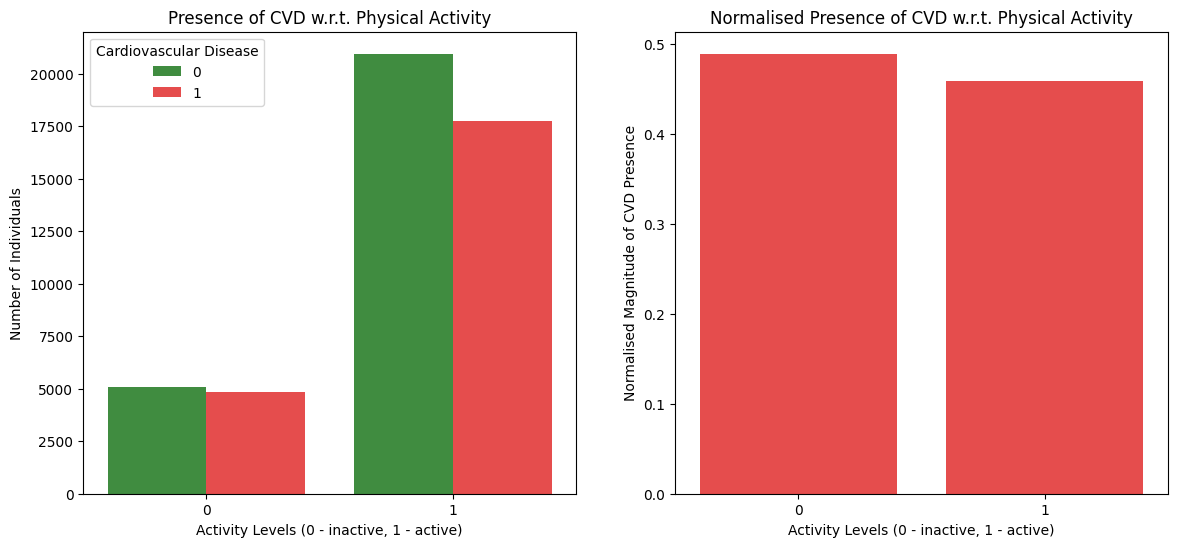

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Grouping by 'active' and 'cardio' columns and calculating counts
grouped = df.groupby(['active', 'cardio']).size().unstack().reset_index()

# Melt the DataFrame for Seaborn's barplot
melted = pd.melt(grouped, id_vars='active', var_name='Cardiovascular Disease', value_name='Count')

# Plotting the grouped bar plot
inac_cvd_bar = sns.barplot(data=melted, x='active', y='Count', hue='Cardiovascular Disease', palette={0: 'green', 1: 'red'}, alpha=0.8, ax=axes[0])
inac_cvd_bar.set_title("Presence of CVD w.r.t. Physical Activity")
inac_cvd_bar.set_xlabel("Activity Levels (0 - inactive, 1 - active)")
inac_cvd_bar.set_ylabel("Number of Individuals")

# Calculate percentages
grouped_total = df.groupby('active').size().reset_index(name='Total')
grouped_cvd = df[df['cardio'] == 1].groupby('active').size().reset_index(name='CVD')

# Merge the total and CVD counts
merged = pd.merge(grouped_total, grouped_cvd, on='active')

# Calculate percentages
merged['Percentage_CVD'] = (merged['CVD'] / merged['Total'])

# Plotting the stacked bar plot
inac_cvd_norm_bar = sns.barplot(data=merged, x='active', y='Percentage_CVD', color='red', alpha=0.8, ax=axes[1])
inac_cvd_norm_bar.set_title("Normalised Presence of CVD w.r.t. Physical Activity")
inac_cvd_norm_bar.set_xlabel("Activity Levels (0 - inactive, 1 - active)")
inac_cvd_norm_bar.set_ylabel("Normalised Magnitude of CVD Presence")

## 5.6 - BMI w.r.t. CVD

/var/folders/gh/fp8cyv3j0xv6hnfcq67g5b4w0000gn/T/ipykernel_42336/420321428.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  mbi_cvd_norm_bar.set_xticklabels(mbi_cvd_norm_bar.get_xticklabels(), rotation=-90)


Text(0, 0.5, 'Normalised CVD Presence')

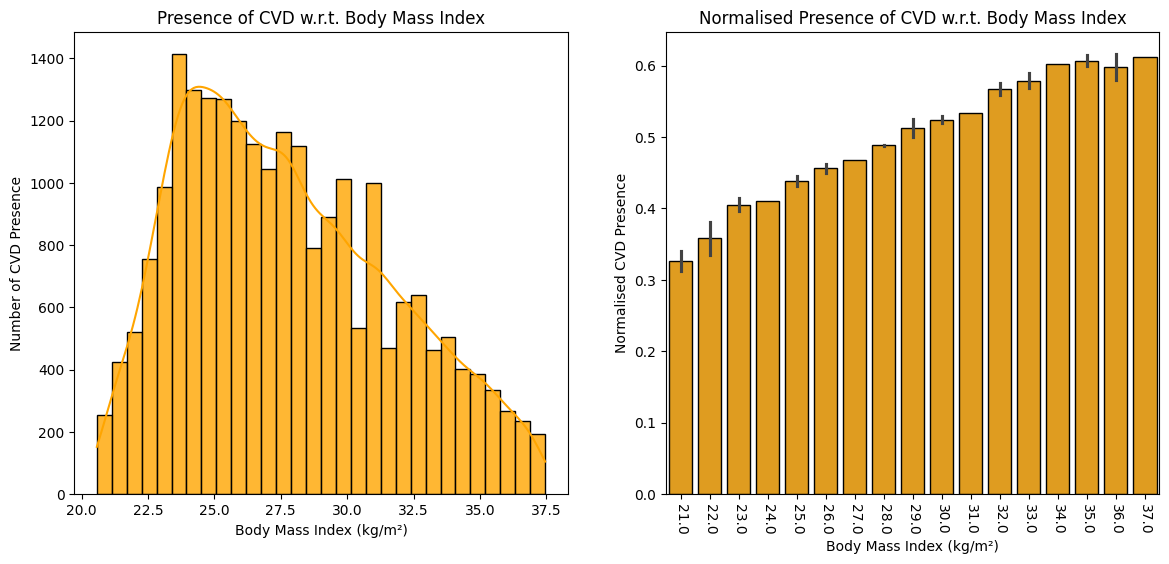

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

cvd_present = df[df['cardio'] == 1]
cvd_absent = df[df['cardio'] == 0]

bmi_cvd_hist = sns.histplot(data=cvd_present, x='bmi', bins=30, kde=True, color='orange', alpha=0.8, ax=axes[0])
bmi_cvd_hist.set_title("Presence of CVD w.r.t. Body Mass Index")
bmi_cvd_hist.set_xlabel("Body Mass Index (kg/m²)")
bmi_cvd_hist.set_ylabel("Number of CVD Presence")

num_bins = 30
bins=np.linspace(df['bmi'].min(),df['bmi'].max(),num_bins)

cvd_present_hist = np.histogram(cvd_present['bmi'],bins=bins)
cvd_absent_hist = np.histogram(cvd_absent['bmi'],bins=bins)

cvd_rates = cvd_present_hist[0]/(cvd_present_hist[0]+cvd_absent_hist[0])

mbi_cvd_norm_bar = sns.barplot(
    x=bins[:-1].round(),
    y=cvd_rates,
    ax=axes[1],
    color='orange',
    edgecolor="0",
)
mbi_cvd_norm_bar.set_title("Normalised Presence of CVD w.r.t. Body Mass Index")
mbi_cvd_norm_bar.set_xticklabels(mbi_cvd_norm_bar.get_xticklabels(), rotation=-90)
mbi_cvd_norm_bar.set_xlabel("Body Mass Index (kg/m²)")
mbi_cvd_norm_bar.set_ylabel("Normalised CVD Presence")

## 5.7 - Age w.r.t. CVD

/var/folders/gh/fp8cyv3j0xv6hnfcq67g5b4w0000gn/T/ipykernel_42336/4109128432.py:17: RuntimeWarning: invalid value encountered in divide
  cvd_rates = cvd_present_hist[0]/(cvd_present_hist[0]+cvd_absent_hist[0])
/var/folders/gh/fp8cyv3j0xv6hnfcq67g5b4w0000gn/T/ipykernel_42336/4109128432.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  age_cvd_norm_bar.set_xticklabels(age_cvd_norm_bar.get_xticklabels(), rotation=-90)


Text(0, 0.5, 'Normalised CVD Presence')

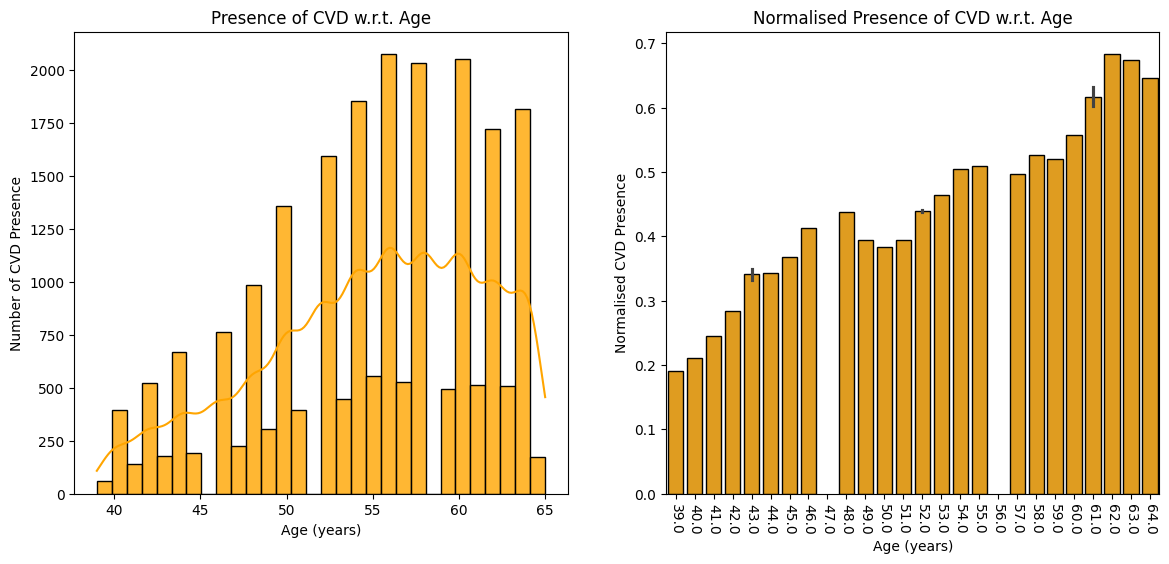

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

cvd_present = df[df['cardio'] == 1]
cvd_absent = df[df['cardio'] == 0]

age_cvd_hist = sns.histplot(data=cvd_present, x='age', bins=30, kde=True, color='orange', alpha=0.8, ax=axes[0])
age_cvd_hist.set_title("Presence of CVD w.r.t. Age")
age_cvd_hist.set_xlabel("Age (years)")
age_cvd_hist.set_ylabel("Number of CVD Presence")

num_bins = 30
bins=np.linspace(39,df['age'].max(),num_bins)

cvd_present_hist = np.histogram(cvd_present['age'],bins=bins)
cvd_absent_hist = np.histogram(cvd_absent['age'],bins=bins)

cvd_rates = cvd_present_hist[0]/(cvd_present_hist[0]+cvd_absent_hist[0])

age_cvd_norm_bar = sns.barplot(
    x=bins[:-1].round(),
    y=cvd_rates,
    ax=axes[1],
    color='orange',
    edgecolor="0",
)
age_cvd_norm_bar.set_title("Normalised Presence of CVD w.r.t. Age")
age_cvd_norm_bar.set_xticklabels(age_cvd_norm_bar.get_xticklabels(), rotation=-90)
age_cvd_norm_bar.set_xlabel("Age (years)")
age_cvd_norm_bar.set_ylabel("Normalised CVD Presence")

## 5.8 - Gender w.r.t. CVD

Text(0, 0.5, 'Normalised Magnitude of CVD Presence')

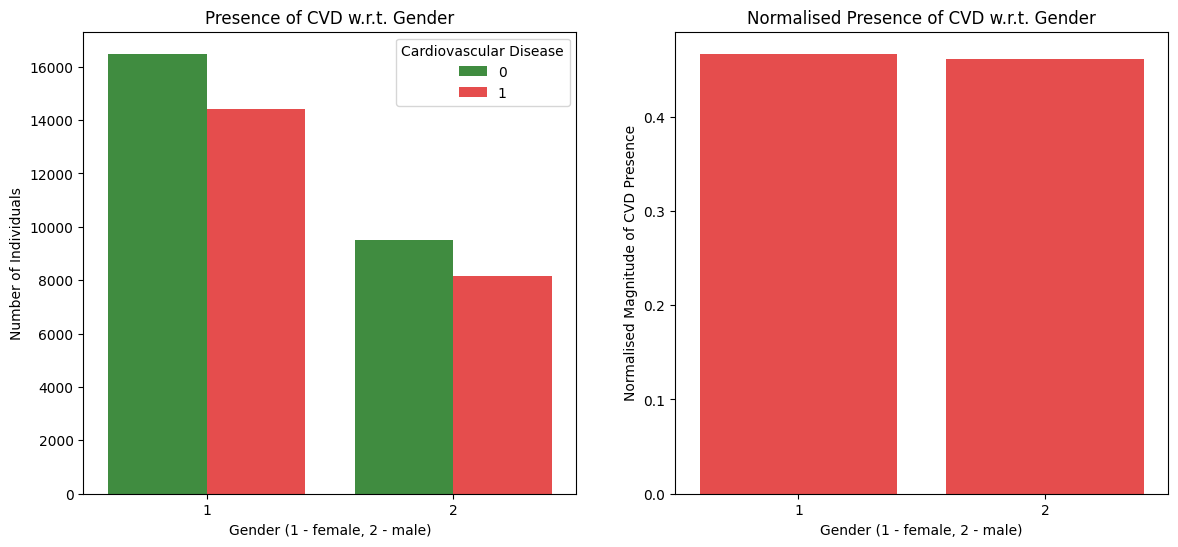

In [39]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Grouping by 'gender' and 'cardio' columns and calculating counts
grouped = df.groupby(['gender', 'cardio']).size().unstack().reset_index()

# Melt the DataFrame for Seaborn's barplot
melted = pd.melt(grouped, id_vars='gender', var_name='Cardiovascular Disease', value_name='Count')

gen_cvd_bar = sns.barplot(data=melted, x='gender', y='Count', hue='Cardiovascular Disease', palette={0: 'green', 1: 'red'}, alpha=0.8, ax=axes[0])
gen_cvd_bar.set_title("Presence of CVD w.r.t. Gender")
gen_cvd_bar.set_xlabel("Gender (1 - female, 2 - male)")
gen_cvd_bar.set_ylabel("Number of Individuals")

# Calculate percentages
grouped_total = df.groupby('gender').size().reset_index(name='Total')
grouped_cvd = df[df['cardio'] == 1].groupby('gender').size().reset_index(name='CVD')

# Merge the total and CVD counts
merged = pd.merge(grouped_total, grouped_cvd, on='gender')

# Calculate percentages
merged['Percentage_CVD'] = (merged['CVD'] / merged['Total'])
# Plotting the stacked bar plot
gen_cvd_norm_bar = sns.barplot(data=merged, x='gender', y='Percentage_CVD', color='red', alpha=0.8, ax=axes[1])
gen_cvd_norm_bar.set_title("Normalised Presence of CVD w.r.t. Gender")
gen_cvd_norm_bar.set_xlabel("Gender (1 - female, 2 - male)")
gen_cvd_norm_bar.set_ylabel("Normalised Magnitude of CVD Presence")

## 5.9 - Gender w.r.t. Age w.r.t. CVD

/var/folders/gh/fp8cyv3j0xv6hnfcq67g5b4w0000gn/T/ipykernel_42336/3717014449.py:32: RuntimeWarning: invalid value encountered in divide
  cvd_rates = cvd_present_hist[0]/(cvd_present_hist[0]+cvd_absent_hist[0])
/var/folders/gh/fp8cyv3j0xv6hnfcq67g5b4w0000gn/T/ipykernel_42336/3717014449.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  female_cvd_norm_bar.set_xticklabels(female_cvd_norm_bar.get_xticklabels(), rotation=-90)
/var/folders/gh/fp8cyv3j0xv6hnfcq67g5b4w0000gn/T/ipykernel_42336/3717014449.py:64: RuntimeWarning: invalid value encountered in divide
  cvd_rates = cvd_present_hist[0]/(cvd_present_hist[0]+cvd_absent_hist[0])
/var/folders/gh/fp8cyv3j0xv6hnfcq67g5b4w0000gn/T/ipykernel_42336/3717014449.py:75: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  male_cvd_norm_bar.set_xticklabels(male_cvd_norm_bar.get_xticklabe

Text(0, 0.5, 'Normalised CVD Presence')

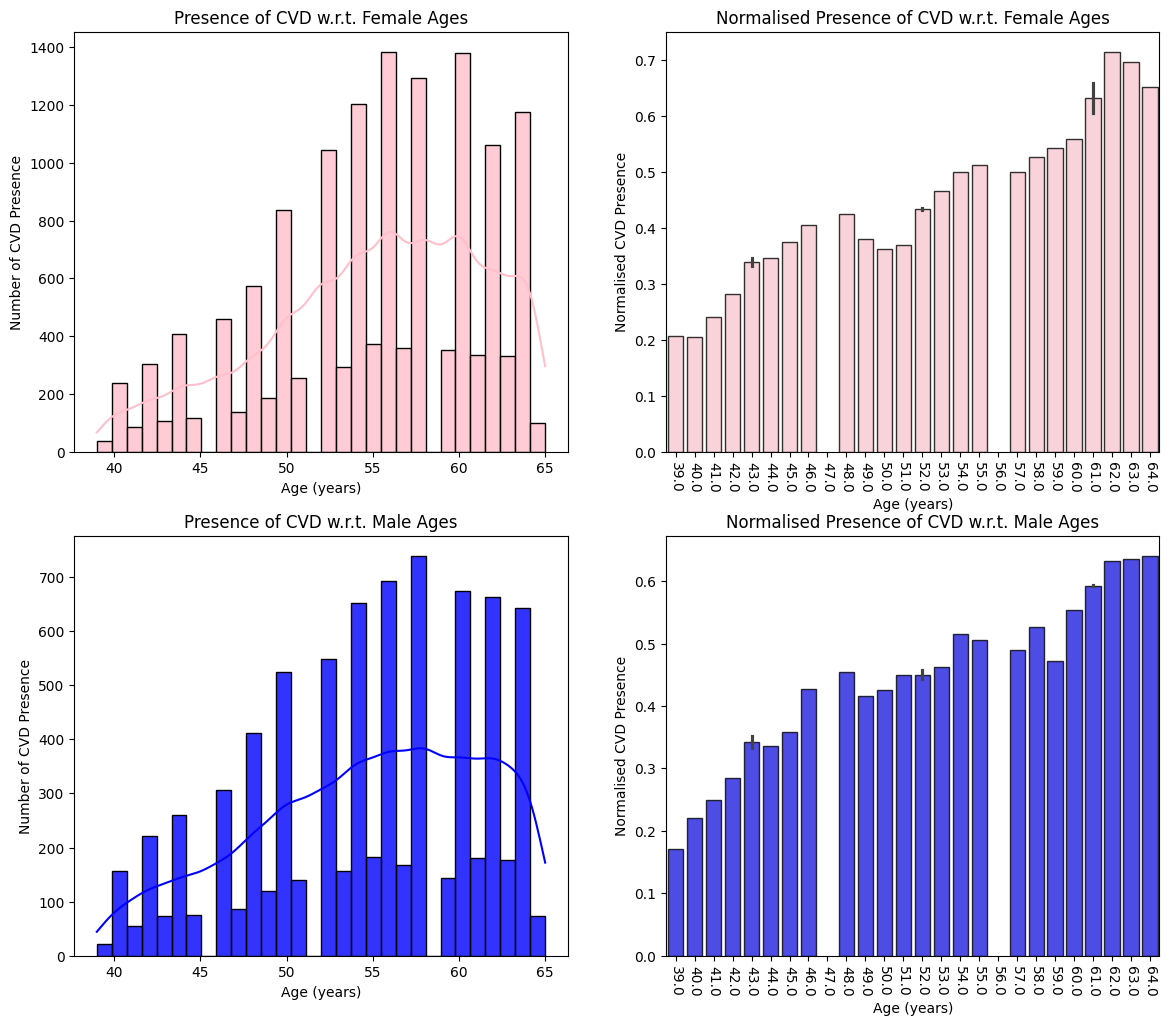

In [40]:
# fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# male_cvd = df[(df['cardio'] == 1) & (df['gender'] == 2)]
# sns.histplot(data=male_cvd, x='age', bins=10, kde=True, color='blue', alpha=0.8, ax=axes[0]).set_title("Presence of CVD w.r.t. Male Ages")

# female_cvd = df[(df['cardio'] == 1) & (df['gender'] == 1)]
# sns.histplot(data=female_cvd, x='age', bins=10, kde=True, color='pink', alpha=0.8, ax=axes[1]).set_title("Presence of CVD w.r.t. Female Ages")






# sns.countplot(data=df, x="age", hue="cardio", palette={0: 'green', 1: 'red'}).set_title("Presence of CVD w.r.t. Age")

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

female_cvd_present = df[(df['cardio'] == 1) & (df['gender'] == 1)]
female_cvd_absent = df[(df['cardio'] == 0) & (df['gender'] == 1)]

female_cvd_hist = sns.histplot(data=female_cvd_present, x='age', bins=30, kde=True, color='pink', alpha=0.8, ax=axes[0, 0])
female_cvd_hist.set_title("Presence of CVD w.r.t. Female Ages")
female_cvd_hist.set_xlabel("Age (years)")
female_cvd_hist.set_ylabel("Number of CVD Presence")

num_bins = 30
bins=np.linspace(39,df['age'].max(),num_bins)

cvd_present_hist = np.histogram(female_cvd_present['age'],bins=bins)
cvd_absent_hist = np.histogram(female_cvd_absent['age'],bins=bins)

cvd_rates = cvd_present_hist[0]/(cvd_present_hist[0]+cvd_absent_hist[0])

female_cvd_norm_bar = sns.barplot(
    x=bins[:-1].round(),
    y=cvd_rates,
    ax=axes[0,1],
    color='pink',
    alpha=0.8,
    edgecolor="0",
)
female_cvd_norm_bar.set_title("Normalised Presence of CVD w.r.t. Female Ages")
female_cvd_norm_bar.set_xticklabels(female_cvd_norm_bar.get_xticklabels(), rotation=-90)
female_cvd_norm_bar.set_xlabel("Age (years)")
female_cvd_norm_bar.set_ylabel("Normalised CVD Presence")




male_cvd_present = df[(df['cardio'] == 1) & (df['gender'] == 2)]
male_cvd_absent = df[(df['cardio'] == 0) & (df['gender'] == 2)]

male_cvd_hist = sns.histplot(data=male_cvd_present, x='age', bins=30, kde=True, color='blue', alpha=0.8, ax=axes[1, 0])
male_cvd_hist.set_title("Presence of CVD w.r.t. Male Ages")
male_cvd_hist.set_xlabel("Age (years)")
male_cvd_hist.set_ylabel("Number of CVD Presence")

num_bins = 30
bins=np.linspace(39,df['age'].max(),num_bins)

cvd_present_hist = np.histogram(male_cvd_present['age'],bins=bins)
cvd_absent_hist = np.histogram(male_cvd_absent['age'],bins=bins)

cvd_rates = cvd_present_hist[0]/(cvd_present_hist[0]+cvd_absent_hist[0])

male_cvd_norm_bar = sns.barplot(
    x=bins[:-1].round(),
    y=cvd_rates,
    ax=axes[1,1],
    color='blue',
    alpha=0.8,
    edgecolor="0",
)
male_cvd_norm_bar.set_title("Normalised Presence of CVD w.r.t. Male Ages")
male_cvd_norm_bar.set_xticklabels(male_cvd_norm_bar.get_xticklabels(), rotation=-90)
male_cvd_norm_bar.set_xlabel("Age (years)")
male_cvd_norm_bar.set_ylabel("Normalised CVD Presence")

## 5.10 - Alcohol w.r.t. CVD

Text(0, 0.5, 'Normalised Magnitude of CVD Presence')

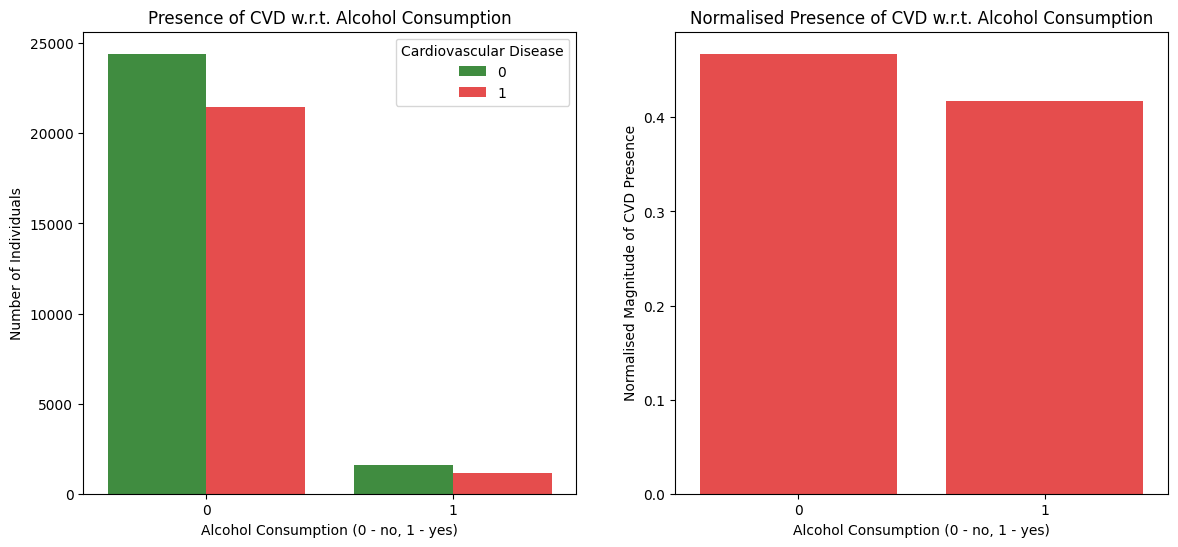

In [41]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Grouping by 'alco' and 'cardio' columns and calculating counts
grouped = df.groupby(['alco', 'cardio']).size().unstack().reset_index()

# Melt the DataFrame for Seaborn's barplot
melted = pd.melt(grouped, id_vars='alco', var_name='Cardiovascular Disease', value_name='Count')

# Plotting the grouped bar plot
alco_cvd_bar = sns.barplot(data=melted, x='alco', y='Count', hue='Cardiovascular Disease', palette={0: 'green', 1: 'red'}, alpha=0.8, ax=axes[0])
alco_cvd_bar.set_title("Presence of CVD w.r.t. Alcohol Consumption")
alco_cvd_bar.set_xlabel("Alcohol Consumption (0 - no, 1 - yes)")
alco_cvd_bar.set_ylabel("Number of Individuals")

# Calculate percentages
grouped_total = df.groupby('alco').size().reset_index(name='Total')
grouped_cvd = df[df['cardio'] == 1].groupby('alco').size().reset_index(name='CVD')

# Merge the total and CVD counts
merged = pd.merge(grouped_total, grouped_cvd, on='alco')

# Calculate percentages
merged['Percentage_CVD'] = (merged['CVD'] / merged['Total'])

# Plotting the stacked bar plot
alco_cvd_norm_bar = sns.barplot(data=merged, x='alco', y='Percentage_CVD', color='red', alpha=0.8, ax=axes[1])
alco_cvd_norm_bar.set_title("Normalised Presence of CVD w.r.t. Alcohol Consumption")
alco_cvd_norm_bar.set_xlabel("Alcohol Consumption (0 - no, 1 - yes)")
alco_cvd_norm_bar.set_ylabel("Normalised Magnitude of CVD Presence")

## 5.11 - Correlation Matrix

Text(0.5, 1.0, 'Feature Correlation Heatmap')

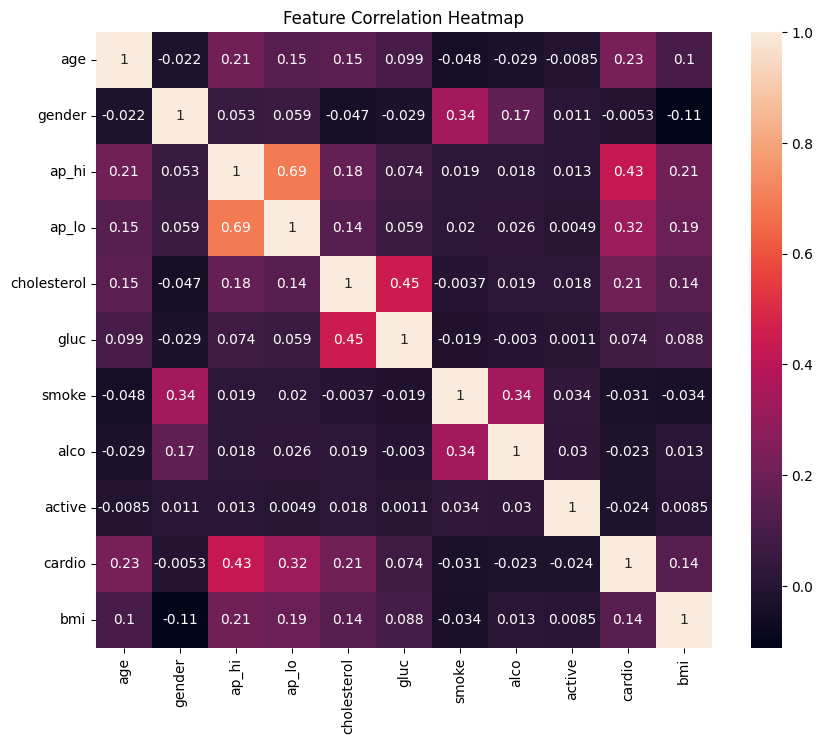

In [42]:
fig,ax = plt.subplots(figsize=(10,8))
correlation = df.select_dtypes(include=['float64','int64']).corr()
sns.heatmap(correlation,ax=ax,vmax=1,square=True, annot=True)
plt.title('Feature Correlation Heatmap')